# Representing Data and Engineering Features

Representing your data in the right way can have a bigger infuence on the performance of a supervised model than the exact parameters you choose.


##### Index:
* Categorical Variables
    * One-Hot-Encoding (Dummy Variables)
    * Numbers Can Encode Categoricals
* OneHotEncoder and ColumnTransformer: Categorical Variables with scikit-learn
* Convenient ColumnTransformer creation with make_columntransformer
* Binning, Discretization, Linear Models, and Trees
* Interactions and Polynomials

In [19]:
import pandas as pd
import numpy as np
import mglearn
import IPython.display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Categorical Variables

The dataset of adult incomes will be used to predict if their salary is above or belowe 50k.


## One-Hot-Encoding (Dummy Variables)

The most common way to represent categorical variables. The idea is to add more features that consist of 0 and 1. Each new feature represents one of the categories.

In [2]:
import os
# The file has no headers naming the columns, so we pass header=None
# and provide the column names explicitly in "names"
adult_path = os.path.join(mglearn.datasets.DATA_PATH, "adult.data")
data = pd.read_csv(
    adult_path, header=None, index_col=False,
    names=['age', 'workclass', 'fnlwgt', 'education',  'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])
# For illustration purposes, we only select some of the columns
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]
# IPython.display allows nice output formatting within the Jupyter notebook
display(data.head())

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


We must check if a column contains meaningful categorical data. If these columns are product of user input, they might require preprocessing (like making man and male the same).

We can check the contents of a column as follows. In this case value_counts() tells us that there are exactly two values for gender in the dataset: Male and Female.

In the real world I should check all the columns to see if they can be encoded, right now that will be skipped.

In [3]:
print(data["gender"].value_counts())

 Male      21790
 Female    10771
Name: gender, dtype: int64


In [4]:
# Encode the data with pandas
print("Original features:\n", list(data.columns), "\n")
data_dummies = pd.get_dummies(data)
print("Features after get_dummies:\n",list(data_dummies.columns))

Original features:
 ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income'] 

Features after get_dummies:
 ['age', 'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'gender_ Female', 'gender_ Male', 'occupation_ ?', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-i

With the transformation we can now transform it into numpy array and pass it to a machine learning model.

One needs to be careful to separate the output variable before passing everything into a model.

##### DANGER:
Column indexing in pandas includes the end of the range. Indexing a numpy array or a list doesn't include the last element.

After all this we can do what we love and train and test the model

In [5]:
features = data_dummies.loc[:, 'age':'occupation_ Transport-moving']
# Extract NumPy arrays
X = features.values
y = data_dummies['income_ >50K'].values
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Test score: {:.2f}".format(logreg.score(X_test, y_test)))

X.shape: (32561, 44)  y.shape: (32561,)
Test score: 0.81


C:\Users\S2G 02\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


##### DANGER
It is important to ensure that the training and test sets have the same encoding and number of features after getting the dummies. This can be done simply by calling the dummies on the whole dataset before separation into train and test sets.

## Numbers Can Encode Categoricals

In the case of the adults, categorial variables where encoded as strings, but categories can also be numbers and should NOT be treated as continuous variables.

The get_dummies from pandas treats all numbers as continuos and will not crate categories from them.

Let's try it.

In [6]:
# create a DataFrame with an integer feature and a categorical string feature
demo_df = pd.DataFrame({'Integer Feature': [0, 1, 2, 1],
                        'Categorical Feature': ['socks', 'fox', 'socks', 'box']})
display(demo_df)

,Integer Feature,Categorical Feature
0,0,socks
1,1,fox
2,2,socks
3,1,box


In [7]:
display(pd.get_dummies(demo_df))

,Integer Feature,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,0,0,0,1
1,1,0,1,0
2,2,0,0,1
3,1,1,0,0


If I want to treat an integer category as a category, I need to ask pandas explicitly to do it.

In [8]:
demo_df["Integer Feature"] = demo_df["Integer Feature"].astype(str)
pd.get_dummies(demo_df, columns = ["Integer Feature", "Categorical Feature"])

,Integer Feature_0,Integer Feature_1,Integer Feature_2,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,1,0,0,0,0,1
1,0,1,0,0,1,0
2,0,0,1,0,0,1
3,0,1,0,1,0,0


# OneHotEncoder and ColumnTransformer: Categorical Variables with scikit-learn

Scikit-learn has also a wa to perform one-hot-encoding with the class OneHoTEncoder. The OneHotEncoder  applies the encoding to all input columns.

In [9]:
from sklearn.preprocessing import OneHotEncoder
# Setting sparce = False means OneHotEncoder will return a numpy array, not a sparse matrix
ohe = OneHotEncoder(sparse = False)
print(ohe.fit_transform(demo_df))

[[1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0.]]


To get the feature names whe use the get_feature_names method. The first trhee columns correspond to the values 0, 1 and 2 from the original dataset, and the last 3 to the 3 values of the feature in the original dataset.

In [10]:
print(ohe.get_feature_names())

['x0_0' 'x0_1' 'x0_2' 'x1_box' 'x1_fox' 'x1_socks']


OneHotEncoder assumes that everything is categorical, but that is not always the case. ColumnTransformer class can help with that.

ColumnTransformer allows to apply difernt transformations to different columns in the input data.

In [12]:
display(data.head())

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


To apply a linear model to the dataset, we would need to scale the numerical data but also make OneHotEncoder with the other ones. This is where ColumnTransformer helps us.

##### DANGER
We need to conserve the column names in order for ColumnTransformer to help us

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
ct = ColumnTransformer([("scaling", StandardScaler(), ["age", "hours-per-week"]),
                       ("onehot", OneHotEncoder(sparse= False),["workclass", "education","gender","occupation"])])




from sklearn.model_selection import train_test_split
# Get all columns apart from income for the features
data_features = data.drop("income", axis = 1)

# Split DataFrame and income
X_train, X_test, y_train, y_test = train_test_split(data_features, data["income"], random_state = 0)

ct.fit(X_train)
X_train_trans = ct.transform(X_train)
print(X_train_trans.shape)

(24420, 44)


C:\Users\S2G 02\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\S2G 02\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\S2G 02\Anaconda3\lib\site-packages\sklearn\pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


We get 44 features as an output, then we can train the Logistic Regression normally.

In [16]:
logreg = LogisticRegression()
logreg.fit(X_train_trans, y_train)

X_test_trans = ct.transform(X_test)
print("Test score: {:.2f}".format(logreg.score(X_test_trans, y_test)))

Test score: 0.81


C:\Users\S2G 02\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\S2G 02\Anaconda3\lib\site-packages\sklearn\pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In this case all the preoprocessing didn't change a thing, but having all the preprocessing inside a Column Transformer can have its benefits (discussed later).

One can access the steps inside ColumnTransformer via the named_transformers_ attribute

In [17]:
ct.named_transformers_

{'scaling': StandardScaler(copy=True, with_mean=True, with_std=True),
 'onehot': OneHotEncoder(categorical_features=None, categories=None,
        dtype=<class 'numpy.float64'>, handle_unknown='error',
        n_values=None, sparse=False)}

# Convenient ColumnTransformer creation with make_columntransformer

There is another way (kinda easier way) to use ColumnTransformers

In [18]:
from sklearn.compose import make_column_transformer
ct = make_column_transformer(
    (['age', 'hours-per-week'], StandardScaler()),
    (['workclass', 'education', 'gender', 'occupation'], OneHotEncoder(sparse = False)))

C:\Users\S2G 02\Anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:739: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


# Binning, Discretization, Linear Models and Trees

It is important to represent data correctly depending on the model that you are trying to use.

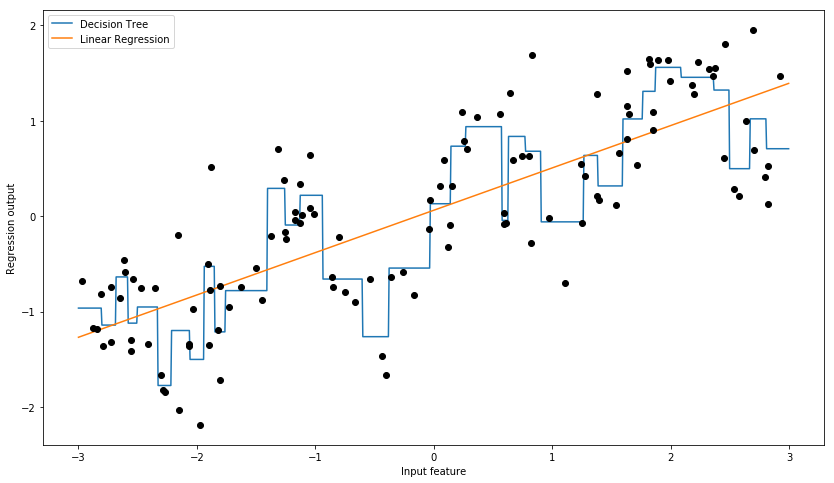

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples = 120)
line = np.linspace(-3, 3, 1000, endpoint= False).reshape(-1,1)

plt.figure(figsize = (14,8))

reg = DecisionTreeRegressor(min_samples_leaf = 3).fit(X, y)
plt.plot(line, reg.predict(line), label="Decision Tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="Linear Regression")

plt.plot(X[:, 0], y, 'o', c = 'k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")
plt.show()

One can make a linear model much more powerful is to use binning (or discretization) of the feature to split it up into multiple features.

We imagine a partition of the input range of the features into a fixed number of bins. A data point will be represented by the bin it falls into.

One can create the bins by sevearl strategies, like making them equidistant or using the quantiles of the data.

This can be done with KBinsDiscretizer. In the following example the first bin contains data points of -2.966 to -2.378 and so on.

KBinsDiscretizer can be used on any number of features.

In [22]:
from sklearn.preprocessing import KBinsDiscretizer

kb = KBinsDiscretizer(n_bins = 10, strategy = 'uniform')
kb.fit(X)

print("Bin edges:\n", kb.bin_edges_)

Bin edges:
 [array([-2.9668673 , -2.37804841, -1.78922951, -1.20041062, -0.61159173,
       -0.02277284,  0.56604605,  1.15486494,  1.74368384,  2.33250273,
        2.92132162])]


By using transform we can encode the bins in which each data point belongs. By default it KBinDiscretizer applies OneHotEncoder, so there is one new feature per bin.

In [23]:
X_binned = kb.transform(X)
X_binned

<120x10 sparse matrix of type '<class 'numpy.float64'>'
	with 120 stored elements in Compressed Sparse Row format>

In [25]:
print(X[:10])
X_binned.toarray()[:10]

[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]
 [-2.06403288]
 [-2.65149833]
 [ 2.19705687]
 [ 0.60669007]
 [ 1.24843547]]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

The first sample (data point) was put in the fourth bin :v

using encode = "onehot-dense" uses hot encoding so we can see the features directly.

In [26]:
kb = KBinsDiscretizer(n_bins = 10, strategy = 'uniform', encode = 'onehot-dense')
kb.fit(X)
X_binned = kb.transform(X)

Now we can create a new linear regression model with the one-hot-encoded data.

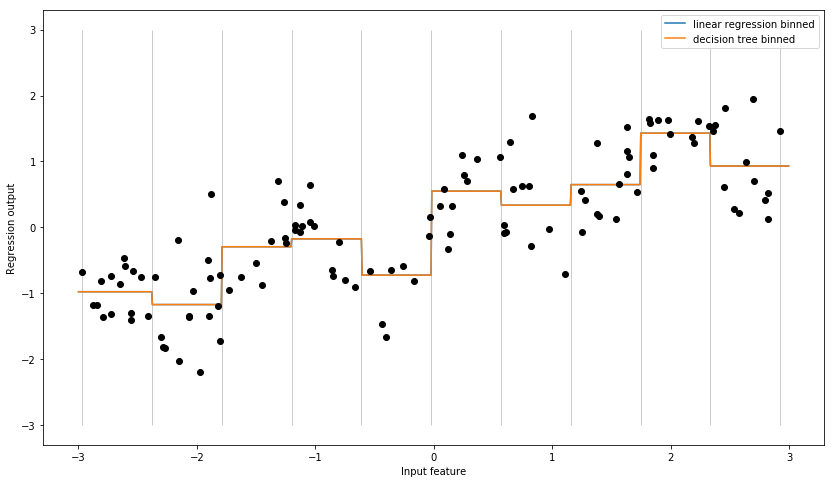

In [32]:
line_binned = kb.transform(line)

plt.figure(figsize = (14,8))
reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='decision tree binned')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")

plt.show()

Binning the feature made the Linear Regression model much more flexible, while it made the Tree model less flexible.

Usually binning data is not beneficial for tree models.

If using a linear model really makes sense, like while working on a very large and high-dimensional dataset, binning can help like a lot.

# Interactons and Polynomials

To enrich feature representation, particularly for linear models, we can add interacton features and polynomials.

We can improve the last model by adding the original features to the bins.

In [33]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)

(120, 11)


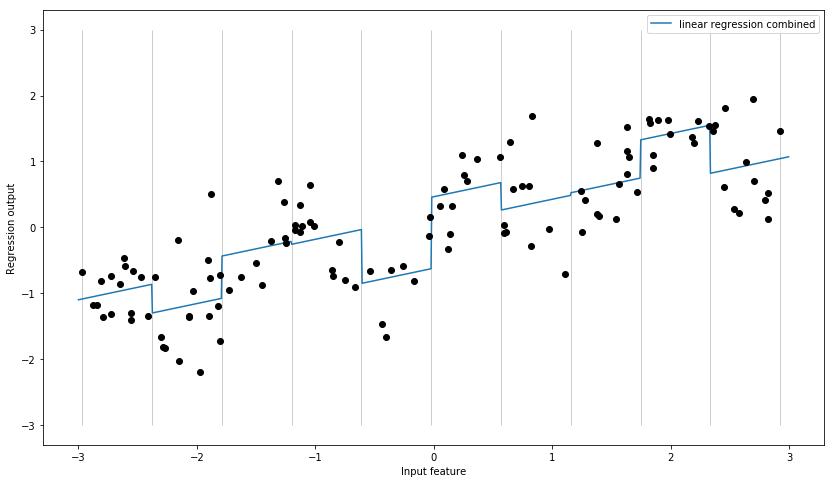

In [35]:
reg = LinearRegression().fit(X_combined, y)

plt.figure(figsize = (14,8))
line_combined = np.hstack([line, line_binned])

plt.plot(line, reg.predict(line_combined), label='linear regression combined')

plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k')

plt.show()

In this example the model learned and offset as well as an slope for each bin. The slope is downwards and shared in all the bins, but we can create a separate slope for each bin. We can add an interaction that tells us which bin a data point is in and whete it lies on the x-axis.

In [41]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(120, 20)


Now the dataset has the indicator of which bin the feature is in and a product of the original feature and the bin indicator. One can think of the product feature as a separate X-axis feature for each bin. It is the original feature within the bin, and zero everywhere else.

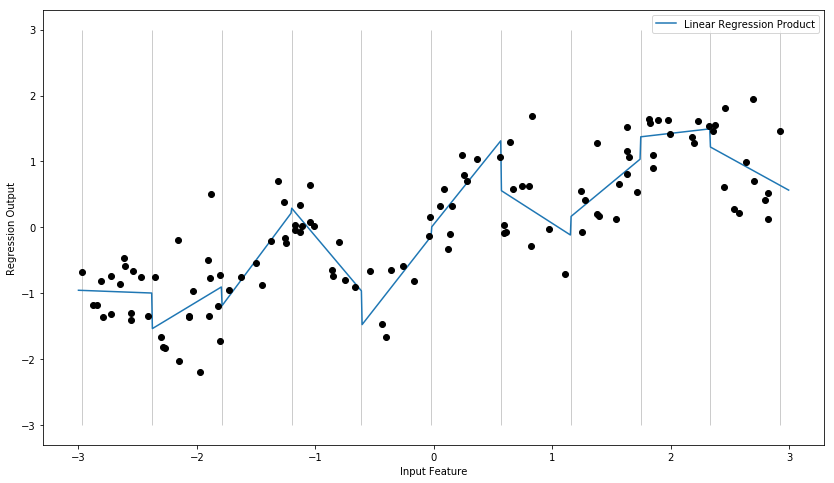

In [45]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])

plt.figure(figsize = (14,8))
plt.plot(line, reg.predict(line_product), label ="Linear Regression Product")

plt.vlines(kb.bin_edges_[0], -3, 3, linewidth = 1, alpha = 0.2)

plt.plot(X[:,0], y, 'o', c = 'k')
plt.ylabel("Regression Output")
plt.xlabel("Input Feature")
plt.legend(loc="best")
plt.show()

Another way to expand a continuos feature is to use polynomials.

This can be done with the PolynomialFeatures class

In [46]:
from sklearn.preprocessing import PolynomialFeatures

#Include polynomials up to X ** 10
# The default "include_bias = True" adds a feature that is constanty 1
poly = PolynomialFeatures(degree = 10, include_bias = False)
poly.fit(X)
X_poly = poly.transform(X)

In [47]:
print("X_poly shape: {}".format(X_poly.shape))

X_poly shape: (120, 10)


In [48]:
print("Entries of X:\n{}".format(X[:5]))
print("Entries of X_poly:\n{}".format(X_poly[:5]))

Entries of X:
[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]
Entries of X_poly:
[[-7.52759287e-01  5.66646544e-01 -4.26548448e-01  3.21088306e-01
  -2.41702204e-01  1.81943579e-01 -1.36959719e-01  1.03097700e-01
  -7.76077513e-02  5.84199555e-02]
 [ 2.70428584e+00  7.31316190e+00  1.97768801e+01  5.34823369e+01
   1.44631526e+02  3.91124988e+02  1.05771377e+03  2.86036036e+03
   7.73523202e+03  2.09182784e+04]
 [ 1.39196365e+00  1.93756281e+00  2.69701700e+00  3.75414962e+00
   5.22563982e+00  7.27390068e+00  1.01250053e+01  1.40936394e+01
   1.96178338e+01  2.73073115e+01]
 [ 5.91950905e-01  3.50405874e-01  2.07423074e-01  1.22784277e-01
   7.26822637e-02  4.30243318e-02  2.54682921e-02  1.50759786e-02
   8.92423917e-03  5.28271146e-03]
 [-2.06388816e+00  4.25963433e+00 -8.79140884e+00  1.81444846e+01
  -3.74481869e+01  7.72888694e+01 -1.59515582e+02  3.29222321e+02
  -6.79478050e+02  1.40236670e+03]]


In [49]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

Polynomial feature names:
['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8', 'x0^9', 'x0^10']


Now we can create a polynomial linear regression

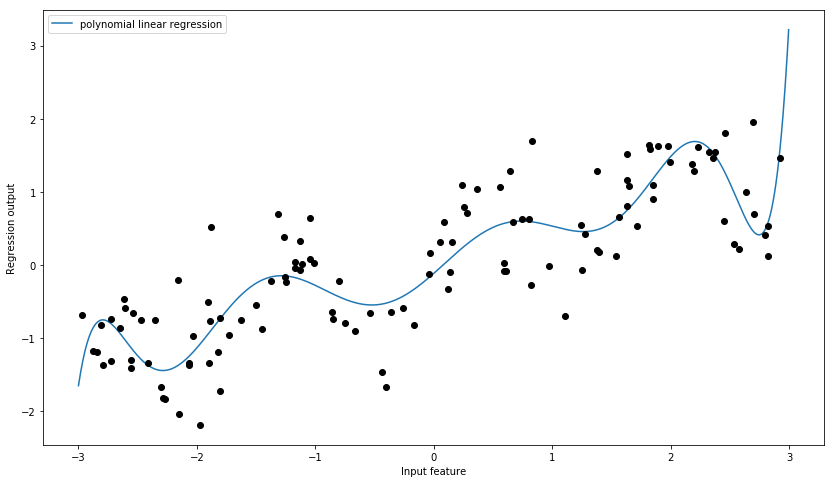

In [50]:
reg = LinearRegression().fit(X_poly, y)

line_poly = poly.transform(line)

plt.figure(figsize = (14,8))

plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

plt.show()

However, polynomials of high degree often behave in extreme ways in extremes or spaces with little data. 

Next there's a kernel SVM model learned on the original data, without any transformation

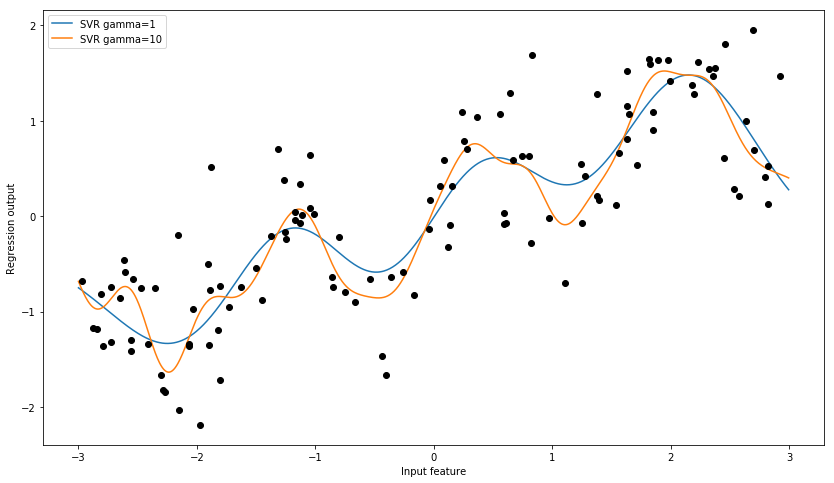

In [51]:
from sklearn.svm import SVR

plt.figure(figsize = (14,8))
for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma={}'.format(gamma))

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

plt.show()

Using a more complex model like the kernel SVM we can get a similarly complex prediction without any explicit transformation.

We can see a better exaple of the polynomial use in the Boston Housing dataset

In [52]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state=0)

# rescale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)